In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import scipy.ndimage

# Load image, convert to 2D array (1D list of RGB triples)

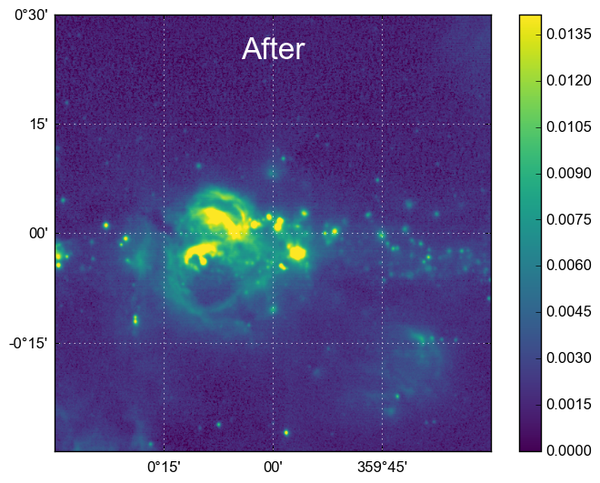

In [3]:
image_obj = Image.open('viridis.png')
image_obj

In [4]:
image = np.asarray(image_obj, dtype=np.uint8)
sh = image.shape
print(sh)
assert len(sh) == 3
assert sh[2] in (3, 4)
image = image.reshape(sh[0] * sh[1], sh[2])[:, :3]
print(image.shape)

(483, 600, 4)
(289800, 3)


# Get 3D histogram

The histogram gives the frequency of each color (RGB triple). If the frequent colors are the ones from a colormap, we are probably using that colormap.

In [5]:
BINS = 64

In [6]:
# Construct the bins
edges = np.repeat((np.arange(BINS + 1, dtype=np.uint8) * 256 / BINS).reshape((1, BINS + 1)), 3, axis=0)

In [7]:
histogram, _ = np.histogramdd(image, bins=edges)
histogram /= image.shape[0]
histogram.shape

(64, 64, 64)

# Build test array

This colormap-dependent array will be multiplicated with the histogram to get a "score" of how close it is to that colormap. It basically has positive values on colors close to the colormap, and negative values elsewhere. White is also accepted (value=0) since it is the usual background color.

In [8]:
import matplotlib.cm

colormap = matplotlib.cm.get_cmap('viridis')

In [9]:
# These are all the colors in the colormap
colors = colormap(np.arange(0.0, 1.0, 0.001))
colors = (colors * 255.0).astype(np.uint8)
colors

array([[ 68,   1,  84, 255],
       [ 68,   1,  84, 255],
       [ 68,   1,  84, 255],
       ..., 
       [253, 231,  36, 255],
       [253, 231,  36, 255],
       [253, 231,  36, 255]], dtype=uint8)

In [10]:
colors.shape

(1000, 4)

In [11]:
Image.fromarray(np.repeat([colors], 20, axis=0))

In [12]:
hist, _ = np.histogramdd(colors[:, :3], bins=edges, normed=False)
hist.shape

(64, 64, 64)

In [13]:
DISTANCE = 4

In [14]:
convo = np.ones((DISTANCE * 2,) * 3, dtype=np.int)

In [15]:
# Reject everything (-4)
testarray = -4 * np.ones(histogram.shape, dtype=np.int)

In [16]:
# Recognize the colors (set them to +1)
recog = scipy.ndimage.filters.convolve(hist, convo, mode='constant', origin=(0, 0, 0))
recog = recog != 0
testarray += recog * 5

In [17]:
# Ignore white (set to 0)
testarray[-DISTANCE:, -DISTANCE:, -DISTANCE:] = 0

# Test colormap

In [18]:
testarray.shape, histogram.shape

((64, 64, 64), (64, 64, 64))

In [19]:
np.dot(testarray.flatten(), histogram.flatten())

0.49017598343685398

| Colormap | Image       | Score    |
|----------|-------------|----------|
| Jet      | jet.png     | +0.48075 |
| Jet      | viridis.png | -2.86543 |
| Jet      | jet-in.png  | +0.92779 |
| Jet      | viri-in.png | -3.99999 |
| Jet      | random.jpg  | -3.46871 |
| Viridis  | jet.png     | -2.85969 |
| Viridis  | viridis.png | +0.49018 |
| Viridis  | jet-in.png  | -3.99497 |
| Viridis  | viri-in.png | +0.93998 |
| Jet      | random.jpg  | -3.46523 |